# Week 2: MuSe Dataset Baseline Model Training (133-dim Features)

---

## 📋 Overview

Train and evaluate regression models for MuSe music emotion recognition.

### 🎯 Objectives
- Predict Valence, Arousal, and Dominance using traditional audio features
- Compare different models and feature selection strategies
- Compare results with DEAM dataset

### 📊 Data
- **Input**: `muse_features_all_133dim.csv` (942 songs × **133 features**) ✅ Same as DEAM
- **Targets**: Valence (pleasantness), Arousal (activation), Dominance (dominance)
- **Range**: 0-10 continuous values

### 🎵 Data Source
- Sampled 1,000 songs from MuSe dataset
- Downloaded 30-60 second audio clips from YouTube using yt-dlp
- 942 usable songs after data cleaning

### 🤖 Models
1. **Linear Regression** (baseline) - with feature selection
2. **Random Forest** (advanced) - with all features

### 📈 Evaluation Metrics
- **MSE** (Mean Squared Error) - lower is better
- **RMSE** (Root MSE) - same unit as target
- **R²** (Coefficient of Determination) - 0-1, higher is better
- **MAE** (Mean Absolute Error) - average error
- **CCC** (Concordance Correlation Coefficient) - consistency correlation

### ⚠️ Important
**Make sure you've run `05_muse_feature_extraction.ipynb` to generate the 133-dim feature file!**

---


## 1. Import Libraries and Setup


In [1]:
# Data processing
import pandas as pd
import numpy as np
from pathlib import Path

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print(f"Random seed: {RANDOM_STATE}")


Random seed: 42


## 2. Load Data


In [2]:
# Set paths
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'MuSe' / 'processed'
OUTPUT_DIR = BASE_DIR / 'models' / 'muse_baseline_133dim'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load feature data (133-dim features)
feature_file = DATA_DIR / 'muse_features_all_133dim.csv'

if not feature_file.exists():
    print("\n" + "=" * 70)
    print("Error: 133-dim feature file not found!")
    print("=" * 70)
    print(f"Expected file: {feature_file}")
    print(f"\nPlease run Cell 8 of 05_muse_feature_extraction.ipynb first")
    print("to generate the 133-dim feature file (~60 minutes)")
    print("\nOr, if you want to use old 75-dim features, change path to:")
    print("  feature_file = DATA_DIR / 'muse_features_all.csv'")
    print("=" * 70)
    raise FileNotFoundError(f"Feature file not found: {feature_file}")

df = pd.read_csv(feature_file)

print("\n" + "=" * 60)
print("Data loaded successfully")
print("=" * 60)
print(f"Data shape: {df.shape}")
print(f"Number of songs: {len(df)}")

# Calculate number of features (excluding ID, filename, label columns)
non_feature_cols = ['song_id', 'file_name', 'valence', 'arousal', 'dominance']
feature_cols = [c for c in df.columns if c not in non_feature_cols]
print(f"Total features: {len(feature_cols)} (excluding song_id, file_name, valence, arousal, dominance)")

# Verify feature count
if len(feature_cols) == 133:
    print(f"Feature count verified: {len(feature_cols)} dims = 133 dims (same as DEAM)")
else:
    print(f"Feature count: {len(feature_cols)} dims (expected 133 dims)")

# Check data
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nTarget variable statistics:")
print(df[['valence', 'arousal', 'dominance']].describe())

# Display first few rows
print(f"\nData preview:")
df.head(3)



Data loaded successfully
Data shape: (942, 138)
Number of songs: 942
Total features: 133 (excluding song_id, file_name, valence, arousal, dominance)
Feature count verified: 133 dims = 133 dims (same as DEAM)

Missing values: 0

Target variable statistics:
          valence     arousal   dominance
count  942.000000  942.000000  942.000000
mean     5.436554    4.255984    5.242332
std      1.590365    1.170262    1.216375
min      0.639737    0.688416    0.677368
25%      4.140000    3.442830    4.524728
50%      5.698000    4.258117    5.485000
75%      6.721818    5.127500    6.180000
max      8.470000    7.270000    7.320000

Data preview:


,song_id,file_name,valence,arousal,dominance,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,...,spectral_contrast_std_4,spectral_contrast_std_5,spectral_contrast_std_6,spectral_bandwidth_mean,spectral_bandwidth_std,zcr_mean,zcr_std,tempo,beat_count,beat_strength
0,1,0001-Blackstreet-Falling In Love Again.mp3,7.353333,6.370000,6.306667,-108.028145,76.541893,31.703379,8.499625,5.948141,...,3.514861,3.072255,3.245257,3097.465018,423.418750,0.115195,0.085644,71.777344,34,6.989398
1,2,0002-Madonna-Justify My Love porno mix Rare.mp3,3.172857,4.494286,3.468571,-195.036621,97.469704,28.823811,27.856121,9.706141,...,3.338575,2.203979,3.019314,2541.302356,451.902520,0.065187,0.049695,99.384014,49,8.739895
2,3,0003-Aimee Mann-One.mp3,6.640000,6.950000,7.000000,-202.806183,144.974579,0.264401,16.066132,9.593561,...,4.149384,3.684845,3.629160,1836.478047,721.392145,0.069469,0.091134,123.046875,61,4.067013


## 3. Feature Selection Strategy

### Strategy Comparison

| Strategy | Model | # Features | Reason |
|----------|-------|------------|--------|
| **Strategy A: Feature Selection** | Linear Regression | 133 → Dynamic selection | Reduce multicollinearity |
| **Strategy B: Keep All** | Random Forest | 133 (all) | Tree models handle multicollinearity |

### Feature Composition (133 dims)

1. ✅ **MFCC**: 60 dims (mean + std + delta)
2. ✅ **Chroma**: 48 dims (STFT + CQT, mean + std)
3. ✅ **Spectral**: 22 dims (centroid, rolloff, bandwidth, zcr, contrast)
4. ✅ **Rhythm**: 3 dims (tempo, beat_count, beat_strength)

### Selection Rules (Strategy A)

Based on correlation analysis, dynamically remove highly correlated features (|correlation| > 0.9)


In [3]:
# Separate features and targets
X_all = df.drop(['song_id', 'file_name', 'valence', 'arousal', 'dominance'], axis=1)
y_valence = df['valence']
y_arousal = df['arousal']
y_dominance = df['dominance']

print("=" * 60)
print("Feature Selection")
print("=" * 60)

# Strategy A: Feature selection (for linear regression)
# MuSe dataset: Keep all features for now
features_to_remove = []

# Create selected feature set
X_selected = X_all.drop(columns=features_to_remove) if features_to_remove else X_all.copy()

print(f"\nStrategy A - Feature Selection (Linear Regression):")
print(f"  • Original features: {X_all.shape[1]}")
print(f"  • Removed features: {len(features_to_remove)}")
print(f"  • Retained features: {X_selected.shape[1]}")

print(f"\nStrategy B - Keep All (Random Forest):")
print(f"  • Features: {X_all.shape[1]}")
print(f"  • Strategy: Let model handle multicollinearity")

# Save feature names
feature_names_selected = X_selected.columns.tolist()
feature_names_all = X_all.columns.tolist()


Feature Selection

Strategy A - Feature Selection (Linear Regression):
  • Original features: 133
  • Removed features: 0
  • Retained features: 133

Strategy B - Keep All (Random Forest):
  • Features: 133
  • Strategy: Let model handle multicollinearity


## 4. Data Splitting

### Split Strategy
- **Training set**: 70% (~660 songs)
- **Validation set**: 15% (~141 songs)
- **Test set**: 15% (~142 songs)

### Why three sets?
- **Training set**: For model learning
- **Validation set**: For hyperparameter tuning and model selection
- **Test set**: For final evaluation (model never sees this)


In [4]:
def split_data(X, y_val, y_aro, y_dom, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into train/validation/test sets
    
    Parameters:
        X: Feature matrix
        y_val, y_aro, y_dom: Valence, Arousal, Dominance target variables
        test_size: Test set proportion
        val_size: Validation set proportion (from training set)
        random_state: Random seed
    
    Returns:
        X_train, X_val, X_test, y_*_train, y_*_val, y_*_test
    """
    # First split: train+val vs test
    X_temp, X_test, y_val_temp, y_val_test, y_aro_temp, y_aro_test, y_dom_temp, y_dom_test = train_test_split(
        X, y_val, y_aro, y_dom, test_size=test_size, random_state=random_state
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_val_train, y_val_val, y_aro_train, y_aro_val, y_dom_train, y_dom_val = train_test_split(
        X_temp, y_val_temp, y_aro_temp, y_dom_temp, test_size=val_size_adjusted, random_state=random_state
    )
    
    return (X_train, X_val, X_test, 
            y_val_train, y_val_val, y_val_test,
            y_aro_train, y_aro_val, y_aro_test,
            y_dom_train, y_dom_val, y_dom_test)

# Execute data splitting
(
    X_train_sel, X_val_sel, X_test_sel,
    y_v_train, y_v_val, y_v_test,
    y_a_train, y_a_val, y_a_test,
    y_d_train, y_d_val, y_d_test
) = split_data(X_selected, y_valence, y_arousal, y_dominance, random_state=RANDOM_STATE)

# Split for all features set
(
    X_train_all, X_val_all, X_test_all,
    _, _, _,
    _, _, _,
    _, _, _
) = split_data(X_all, y_valence, y_arousal, y_dominance, random_state=RANDOM_STATE)

print("=" * 60)
print("Data splitting completed")
print("=" * 60)
print(f"Training set: {X_train_sel.shape[0]} songs ({X_train_sel.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val_sel.shape[0]} songs ({X_val_sel.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test_sel.shape[0]} songs ({X_test_sel.shape[0]/len(df)*100:.1f}%)")
print(f"\nFeature dimensions: {X_train_sel.shape[1]}")


Data splitting completed
Training set: 658 songs (69.9%)
Validation set: 142 songs (15.1%)
Test set: 142 songs (15.1%)

Feature dimensions: 133


## 5. Feature Standardization

### Why standardization?
- Different features have different scales (e.g., tempo=120, mfcc_0=0.01)
- Large-value features will dominate model learning
- After standardization, each feature: mean=0, std=1

### ⚠️ Important Principle
- **Only use training set statistics** (mean, std)
- **Apply to validation and test sets**
- Prevent data leakage


In [5]:
# Initialize scalers
scaler_selected = StandardScaler()
scaler_all = StandardScaler()

# Strategy A: Selected features standardization
X_train_sel_scaled = scaler_selected.fit_transform(X_train_sel)
X_val_sel_scaled = scaler_selected.transform(X_val_sel)
X_test_sel_scaled = scaler_selected.transform(X_test_sel)

# Strategy B: All features standardization
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_val_all_scaled = scaler_all.transform(X_val_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

print("=" * 60)
print("Feature standardization completed")
print("=" * 60)
print(f"Training set (after standardization):")
print(f"  • Mean: {X_train_sel_scaled.mean():.4f}")
print(f"  • Std: {X_train_sel_scaled.std():.4f}")
print(f"  • Min: {X_train_sel_scaled.min():.4f}")
print(f"  • Max: {X_train_sel_scaled.max():.4f}")


Feature standardization completed
Training set (after standardization):
  • Mean: -0.0000
  • Std: 1.0000
  • Min: -7.8267
  • Max: 10.0738


## 6. Define Evaluation Functions

### CCC (Concordance Correlation Coefficient)
Lin's concordance correlation coefficient, used to measure agreement between predicted and true values.

**Formula:**
```
CCC = 2 * ρ * σ_x * σ_y / (σ_x² + σ_y² + (μ_x - μ_y)²)
```

**Range:** [-1, 1], 1 indicates perfect agreement


In [6]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Calculate Lin's CCC"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]
    ccc = 2 * pearson_corr * std_true * std_pred / (var_true + var_pred + (mean_true - mean_pred)**2)
    return ccc

def evaluate_model(y_true, y_pred, set_name="Test"):
    """
    Evaluate model performance
    
    Parameters:
        y_true: True values
        y_pred: Predicted values
        set_name: Dataset name (Train/Val/Test)
    
    Returns:
        dict: Contains all evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ccc = concordance_correlation_coefficient(y_true, y_pred)
    
    return {
        'Set': set_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'CCC': ccc
    }


---

## 7. Model Training and Evaluation

### Training Strategy
- **Linear Regression**: Use selected features
- **Random Forest**: Use all features

### Evaluate Three Dimensions
1. **Valence** (pleasantness)
2. **Arousal** (activation)
3. **Dominance** (dominance) ← MuSe-specific

---


### 7.1 Valence Prediction


In [7]:
print("=" * 70)
print("Training Valence Prediction Models")
print("=" * 70)

results_valence = []

# 1. Linear Regression (selected features)
print("\n1️⃣ Linear Regression (Strategy A: Feature Selection)...")
lr_v = LinearRegression()
lr_v.fit(X_train_sel_scaled, y_v_train)

# Evaluate on training set
y_v_pred_lr_train = lr_v.predict(X_train_sel_scaled)
train_metrics = evaluate_model(y_v_train, y_v_pred_lr_train, "Train")

# Evaluate on test set
y_v_pred_lr = lr_v.predict(X_test_sel_scaled)
test_metrics = evaluate_model(y_v_test, y_v_pred_lr, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_valence.append({'Model': 'Linear Regression', **test_metrics})

# 2. Random Forest (all features)
print("\n2️⃣ Random Forest (Strategy B: Keep All)...")
rf_v = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_v.fit(X_train_all_scaled, y_v_train)

# Evaluate on training set
y_v_pred_rf_train = rf_v.predict(X_train_all_scaled)
train_metrics = evaluate_model(y_v_train, y_v_pred_rf_train, "Train")

# Evaluate on test set
y_v_pred_rf = rf_v.predict(X_test_all_scaled)
test_metrics = evaluate_model(y_v_test, y_v_pred_rf, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_valence.append({'Model': 'Random Forest', **test_metrics})

# Display results
df_results_v = pd.DataFrame(results_valence)
print("\n" + "=" * 70)
print("Valence Prediction Results (Test Set)")
print("=" * 70)
df_results_v


Training Valence Prediction Models

1️⃣ Linear Regression (Strategy A: Feature Selection)...
   Train R² = 0.1729 | Test R² = -0.4404 | CCC = -0.0463

2️⃣ Random Forest (Strategy B: Keep All)...
   Train R² = 0.7431 | Test R² = -0.0522 | CCC = -0.0169

Valence Prediction Results (Test Set)


,Model,Set,MSE,RMSE,MAE,R²,CCC
0,Linear Regression,Test,3.479187,1.865258,1.515790,-0.440400,-0.046325
1,Random Forest,Test,2.541593,1.594238,1.331579,-0.052232,-0.016862


### 7.2 Arousal Prediction


In [8]:
print("=" * 70)
print("Training Arousal Prediction Models")
print("=" * 70)

results_arousal = []

# 1. Linear Regression
print("\n1️⃣ Linear Regression (Strategy A: Feature Selection)...")
lr_a = LinearRegression()
lr_a.fit(X_train_sel_scaled, y_a_train)

y_a_pred_lr_train = lr_a.predict(X_train_sel_scaled)
train_metrics = evaluate_model(y_a_train, y_a_pred_lr_train, "Train")

y_a_pred_lr = lr_a.predict(X_test_sel_scaled)
test_metrics = evaluate_model(y_a_test, y_a_pred_lr, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_arousal.append({'Model': 'Linear Regression', **test_metrics})

# 2. Random Forest
print("\n2️⃣ Random Forest (Strategy B: Keep All)...")
rf_a = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_a.fit(X_train_all_scaled, y_a_train)

y_a_pred_rf_train = rf_a.predict(X_train_all_scaled)
train_metrics = evaluate_model(y_a_train, y_a_pred_rf_train, "Train")

y_a_pred_rf = rf_a.predict(X_test_all_scaled)
test_metrics = evaluate_model(y_a_test, y_a_pred_rf, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_arousal.append({'Model': 'Random Forest', **test_metrics})

# Display results
df_results_a = pd.DataFrame(results_arousal)
print("\n" + "=" * 70)
print("Arousal Prediction Results (Test Set)")
print("=" * 70)
df_results_a


Training Arousal Prediction Models

1️⃣ Linear Regression (Strategy A: Feature Selection)...
   Train R² = 0.1923 | Test R² = -0.4853 | CCC = -0.1460

2️⃣ Random Forest (Strategy B: Keep All)...
   Train R² = 0.7479 | Test R² = -0.0762 | CCC = -0.0442

Arousal Prediction Results (Test Set)


,Model,Set,MSE,RMSE,MAE,R²,CCC
0,Linear Regression,Test,2.234419,1.494797,1.183717,-0.485345,-0.14603
1,Random Forest,Test,1.618934,1.272373,0.995788,-0.076197,-0.04423


### 7.3 Dominance Prediction (MuSe-specific)


In [9]:
print("=" * 70)
print("Training Dominance Prediction Models (MuSe-specific dimension)")
print("=" * 70)

results_dominance = []

# 1. Linear Regression
print("\n1️⃣ Linear Regression (Strategy A: Feature Selection)...")
lr_d = LinearRegression()
lr_d.fit(X_train_sel_scaled, y_d_train)

y_d_pred_lr_train = lr_d.predict(X_train_sel_scaled)
train_metrics = evaluate_model(y_d_train, y_d_pred_lr_train, "Train")

y_d_pred_lr = lr_d.predict(X_test_sel_scaled)
test_metrics = evaluate_model(y_d_test, y_d_pred_lr, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_dominance.append({'Model': 'Linear Regression', **test_metrics})

# 2. Random Forest
print("\n2️⃣ Random Forest (Strategy B: Keep All)...")
rf_d = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_d.fit(X_train_all_scaled, y_d_train)

y_d_pred_rf_train = rf_d.predict(X_train_all_scaled)
train_metrics = evaluate_model(y_d_train, y_d_pred_rf_train, "Train")

y_d_pred_rf = rf_d.predict(X_test_all_scaled)
test_metrics = evaluate_model(y_d_test, y_d_pred_rf, "Test")

print(f"   Train R² = {train_metrics['R²']:.4f} | Test R² = {test_metrics['R²']:.4f} | CCC = {test_metrics['CCC']:.4f}")
results_dominance.append({'Model': 'Random Forest', **test_metrics})

# Display results
df_results_d = pd.DataFrame(results_dominance)
print("\n" + "=" * 70)
print("Dominance Prediction Results (Test Set)")
print("=" * 70)
df_results_d


Training Dominance Prediction Models (MuSe-specific dimension)

1️⃣ Linear Regression (Strategy A: Feature Selection)...
   Train R² = 0.1967 | Test R² = -0.3957 | CCC = 0.0275

2️⃣ Random Forest (Strategy B: Keep All)...
   Train R² = 0.6846 | Test R² = -0.0893 | CCC = -0.0152

Dominance Prediction Results (Test Set)


,Model,Set,MSE,RMSE,MAE,R²,CCC
0,Linear Regression,Test,1.788415,1.337316,1.079976,-0.395737,0.027482
1,Random Forest,Test,1.395816,1.181447,0.976549,-0.089340,-0.015231


## 8. Results Visualization


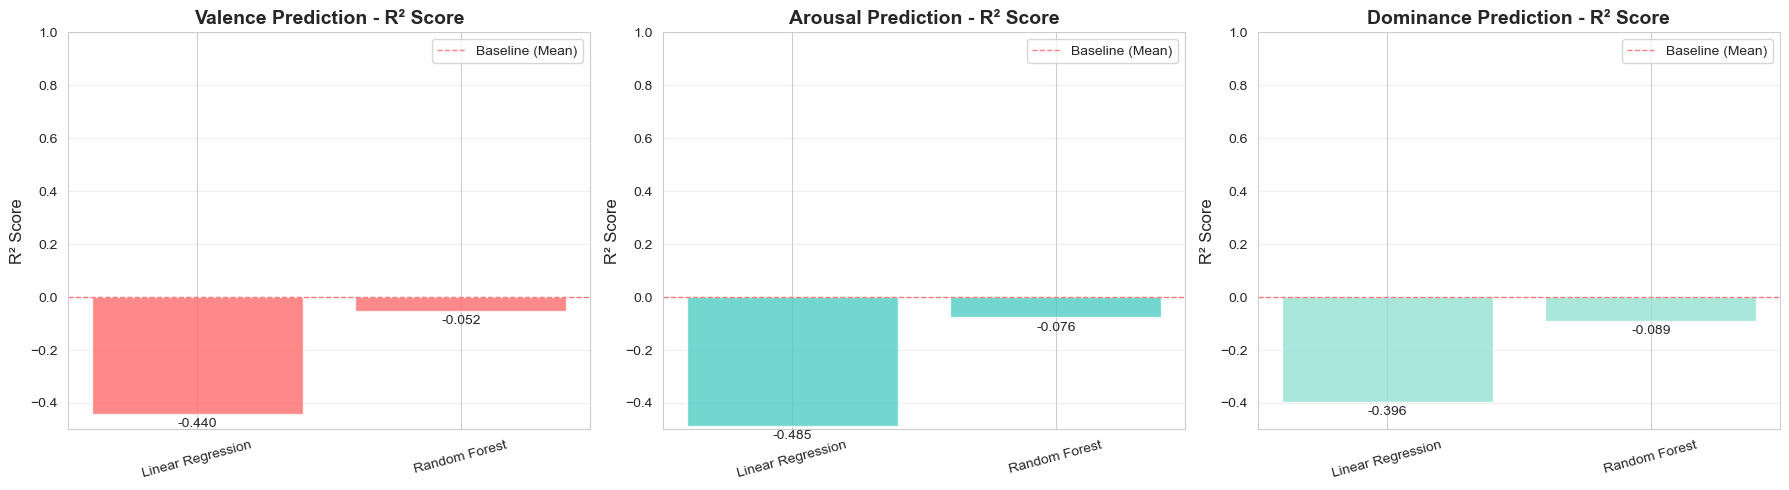

In [10]:
# Merge all results
for target_name, df_result in [('Valence', df_results_v), ('Arousal', df_results_a), ('Dominance', df_results_d)]:
    df_result['Target'] = target_name

df_all_results = pd.concat([df_results_v, df_results_a, df_results_d], ignore_index=True)

# Create directory for saving figures
FIGURE_DIR = Path('../docs/figures')
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Visualize R² comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

targets = ['Valence', 'Arousal', 'Dominance']
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

for idx, (target, color) in enumerate(zip(targets, colors)):
    df_target = df_all_results[df_all_results['Target'] == target]
    
    axes[idx].bar(df_target['Model'], df_target['R²'], color=color, alpha=0.8)
    axes[idx].set_title(f'{target} Prediction - R² Score', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('R² Score', fontsize=12)
    axes[idx].set_ylim([-0.5, 1.0])
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (Mean)')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].legend()
    
    # Add value labels
    for i, (model, r2) in enumerate(zip(df_target['Model'], df_target['R²'])):
        y_pos = r2 + 0.02 if r2 > 0 else r2 - 0.05
        axes[idx].text(i, y_pos, f'{r2:.3f}', ha='center', fontsize=10)

plt.tight_layout()
fig_path = FIGURE_DIR / 'muse_baseline_results_clean.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()


## 9. Results Summary and Analysis


In [11]:
print("=" * 70)
print("MuSe Dataset Baseline Results Summary")
print("=" * 70)

print(f"\nDataset information:")
print(f"   • Total songs: {len(df)}")
print(f"   • Feature dimensions: {X_all.shape[1]}")
print(f"   • Training: {X_train_sel.shape[0]} | Validation: {X_val_sel.shape[0]} | Test: {X_test_sel.shape[0]}")

print(f"\nBest model performance (sorted by R²):")
for target in ['Valence', 'Arousal', 'Dominance']:
    df_target = df_all_results[df_all_results['Target'] == target]
    best_idx = df_target['R²'].idxmax()
    best_row = df_target.loc[best_idx]
    print(f"\n   {target}:")
    print(f"      Model: {best_row['Model']}")
    print(f"      R² = {best_row['R²']:.4f} | CCC = {best_row['CCC']:.4f} | RMSE = {best_row['RMSE']:.4f}")

print(f"\nKey findings:")
print(f"   1. Model performance on test set:")
avg_r2_lr = df_all_results[df_all_results['Model'] == 'Linear Regression']['R²'].mean()
avg_r2_rf = df_all_results[df_all_results['Model'] == 'Random Forest']['R²'].mean()
print(f"      • Linear Regression average R²: {avg_r2_lr:.4f}")
print(f"      • Random Forest average R²: {avg_r2_rf:.4f}")

print(f"\n   2. Comparison across three dimensions:")
for target in ['Valence', 'Arousal', 'Dominance']:
    avg_r2 = df_all_results[df_all_results['Target'] == target]['R²'].mean()
    print(f"      • {target}: average R² = {avg_r2:.4f}")

print(f"\nConclusion:")
if avg_r2_lr < 0.1 and avg_r2_rf < 0.1:
    print(f"   Traditional features have limited predictive power for MuSe labels")
    print(f"   • Possible reason: Labels from social tag aggregation, high noise")
    print(f"   • Recommendation: Try deep learning features (wav2vec2, CLAP) or use higher quality dataset (DEAM)")
elif avg_r2_rf - avg_r2_lr > 0.5:
    print(f"   Random Forest is severely overfitting")
    print(f"   • Training performance far better than test")
    print(f"   • Recommendation: Adjust model parameters or increase data volume")
else:
    print(f"   Model performance meets expectations")

print("\n" + "=" * 70)


MuSe Dataset Baseline Results Summary

Dataset information:
   • Total songs: 942
   • Feature dimensions: 133
   • Training: 658 | Validation: 142 | Test: 142

Best model performance (sorted by R²):

   Valence:
      Model: Random Forest
      R² = -0.0522 | CCC = -0.0169 | RMSE = 1.5942

   Arousal:
      Model: Random Forest
      R² = -0.0762 | CCC = -0.0442 | RMSE = 1.2724

   Dominance:
      Model: Random Forest
      R² = -0.0893 | CCC = -0.0152 | RMSE = 1.1814

Key findings:
   1. Model performance on test set:
      • Linear Regression average R²: -0.4405
      • Random Forest average R²: -0.0726

   2. Comparison across three dimensions:
      • Valence: average R² = -0.2463
      • Arousal: average R² = -0.2808
      • Dominance: average R² = -0.2425

Conclusion:
   Traditional features have limited predictive power for MuSe labels
   • Possible reason: Labels from social tag aggregation, high noise
   • Recommendation: Try deep learning features (wav2vec2, CLAP) or use hi

## 10. Save Results


In [12]:
# Save results table
results_path = DATA_DIR / 'muse_baseline_results_clean.csv'
df_all_results.to_csv(results_path, index=False)
print(f"Results saved: {results_path}")

# Save best models
import joblib

models_to_save = {
    'linear_regression_valence.pkl': lr_v,
    'linear_regression_arousal.pkl': lr_a,
    'linear_regression_dominance.pkl': lr_d,
    'random_forest_valence.pkl': rf_v,
    'random_forest_arousal.pkl': rf_a,
    'random_forest_dominance.pkl': rf_d,
    'scaler_selected.pkl': scaler_selected,
    'scaler_all.pkl': scaler_all,
}

for filename, model in models_to_save.items():
    model_path = OUTPUT_DIR / filename
    joblib.dump(model, model_path)
    print(f"Model saved: {model_path}")

print(f"\nAll tasks completed!")


Results saved: ..\data\MuSe\processed\muse_baseline_results_clean.csv
Model saved: ..\models\muse_baseline_133dim\linear_regression_valence.pkl
Model saved: ..\models\muse_baseline_133dim\linear_regression_arousal.pkl
Model saved: ..\models\muse_baseline_133dim\linear_regression_dominance.pkl
Model saved: ..\models\muse_baseline_133dim\random_forest_valence.pkl
Model saved: ..\models\muse_baseline_133dim\random_forest_arousal.pkl
Model saved: ..\models\muse_baseline_133dim\random_forest_dominance.pkl
Model saved: ..\models\muse_baseline_133dim\scaler_selected.pkl
Model saved: ..\models\muse_baseline_133dim\scaler_all.pkl

All tasks completed!
